<h1 align='center'> Efficient Net Learning and Understanding </h1>

<div>
    <p> This notebook discusses on the learning of efficientnet and working on dataset where words have been written and our final Model will be able to predict which word the provided word is </p>
</div>

In [20]:
import tensorflow as tf
from keras.applications.efficientnet import EfficientNetB0
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

<h3> Understanding Architecture of Efficient Net </h3>

In [ ]:
model=EfficientNetB0()
model.summary()
del model

<h3> Pre Processing Dataset </h3>

In [18]:
def convert_image_to_tensor(path):
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.asarray(img)
    return img

images_list=[]
labels_list=[]
labels_map={}
label_val=0
i='data_1/natural_images'
for folder in os.listdir(i):
    labels_map[label_val]=folder
    for file in os.listdir(i+'/'+folder):
        images_list.append(i+'/'+folder+'/'+file)
        labels_list.append(label_val)
    label_val+=1

labels_map

{0: 'airplane',
 1: 'car',
 2: 'cat',
 3: 'dog',
 4: 'flower',
 5: 'fruit',
 6: 'motorbike',
 7: 'person'}

In [5]:
print(len(images_list),len(labels_list))
layers=tf.keras.layers.CategoryEncoding(num_tokens=len(list(set(labels_list))), output_mode="one_hot")
labels_list=np.array(layers(labels_list))
images_list=np.array([convert_image_to_tensor(i) for i in images_list])

6899 6899


In [6]:
X,Xtest,Y,Ytest=train_test_split(images_list,labels_list)

<h3> Custom Sizing the image and creating transfer learning architecture </h3>

In [ ]:

input_val=tf.keras.layers.Input(shape=(224,224,3))

model=EfficientNetB0(include_top=False,input_tensor=input_val,weights='imagenet')

for i in range(int(len(model.layers) * 0.75)):
    model.layers[i].trainable = False

#model.trainable = False


x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#x=tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(len(labels_map), activation="softmax", name="pred")(x)

model=tf.keras.Model(inputs=input_val,outputs=output)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

In [30]:
callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',mode='auto',restore_best_weights=True )
hist=model.fit(X,Y,validation_data=(Xtest,Ytest),epochs=10,callbacks=[callback],batch_size=128)

Epoch 1/10
41/41 [==============================] - 123s 3s/step - loss: 0.1157 - accuracy: 0.9660 - val_loss: 0.0210 - val_accuracy: 0.9942
Epoch 2/10
41/41 [==============================] - 127s 3s/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.0156 - val_accuracy: 0.9971
Epoch 3/10
41/41 [==============================] - 126s 3s/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0182 - val_accuracy: 0.9965
Epoch 4/10
41/41 [==============================] - 126s 3s/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0206 - val_accuracy: 0.9965
Epoch 5/10
41/41 [==============================] - 122s 3s/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 0.0434 - val_accuracy: 0.9942


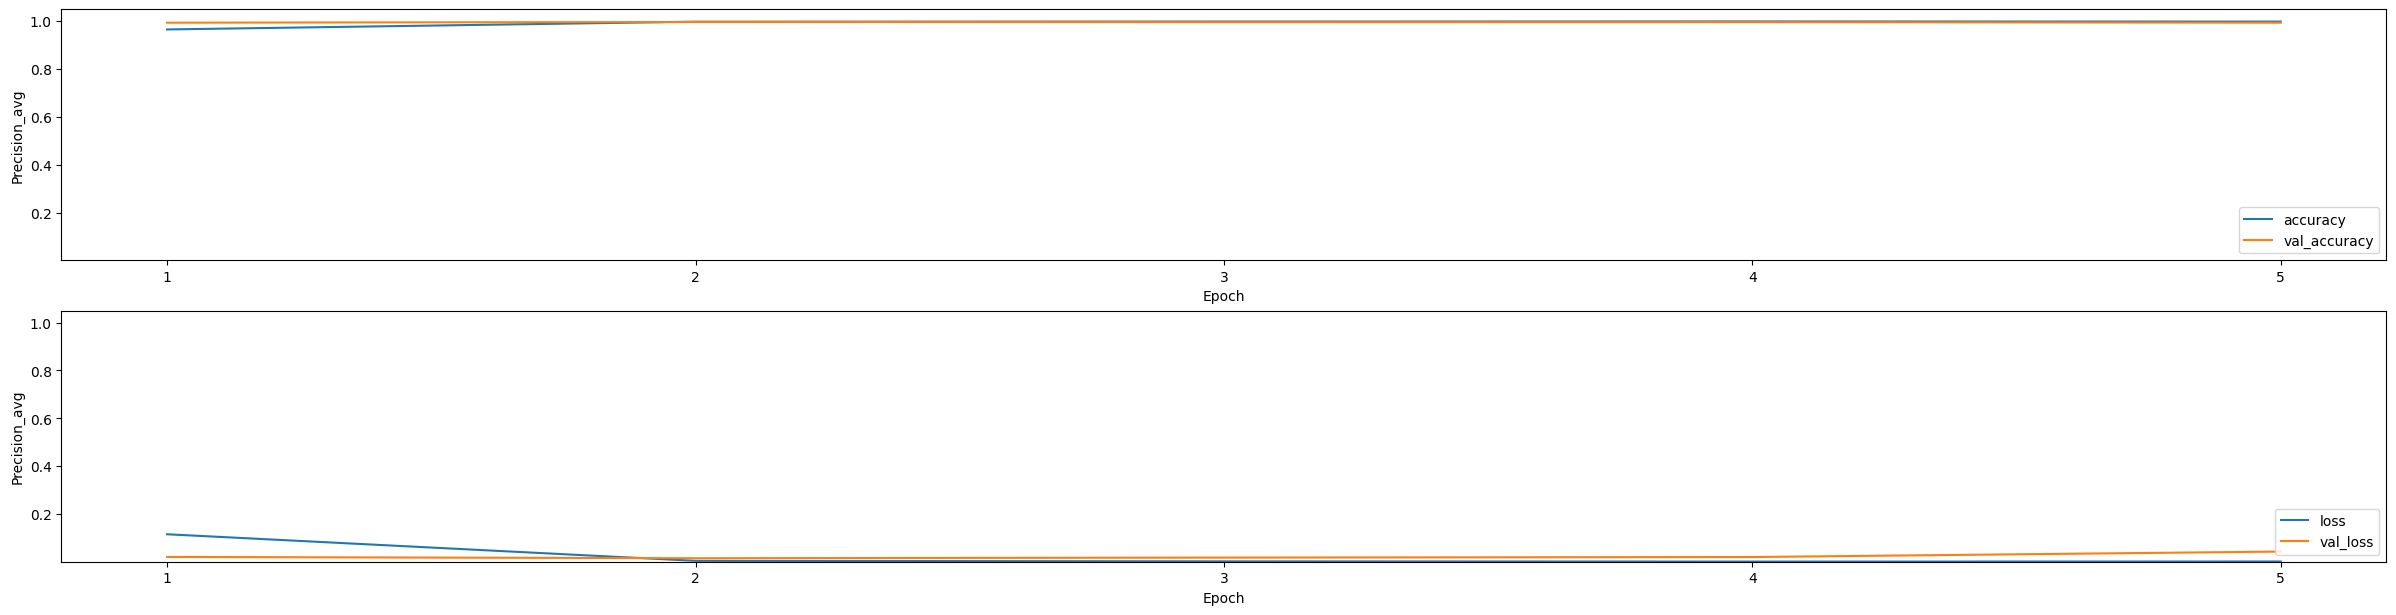

In [31]:
def plot_metrics_for_training(history):
    
    plt.figure(figsize=(30, 15))
    plt.subplot(411)
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label = 'val_accuracy')
    plt.xticks(np.arange(len(history['accuracy'])), np.arange(1, len(history['accuracy'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Precision_avg')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(412)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.xticks(np.arange(len(history['loss'])), np.arange(1, len(history['loss'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Precision_avg')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

plot_metrics_for_training(hist.history)

<h3> Inference Testing </h3>

1/1 [==============================] - 0s 52ms/step
airplane


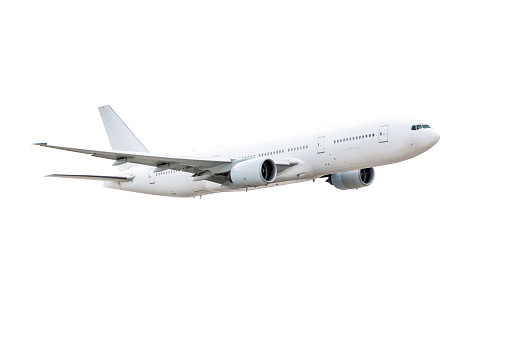

In [42]:
inference_=input('Enter path of the file to test: ')
img=Image.open(inference_)
inference_=convert_image_to_tensor(inference_)
inference_=inference_.reshape(1,inference_.shape[0],inference_.shape[1],inference_.shape[2])
print(labels_map[np.argmax(model.predict(inference_))])
img